In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
# Define dataset details
datasets = [
    {
        "name": "wisconsin data",
        "path": "C:\\Users\\arpitha_work\\Downloads\\TRU MSCDS\\Sem2\\DS Seminar\\Project 1\\Datasets\\wisconsin data.csv",
        "features_numerical": [
            "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean", 
            "compactness_mean", "concavity_mean", "concave points_mean", "symmetry_mean", 
            "fractal_dimension_mean", "radius_se", "texture_se", "perimeter_se", "area_se", 
            "smoothness_se", "compactness_se", "concavity_se", "concave points_se", "symmetry_se", 
            "fractal_dimension_se", "radius_worst", "texture_worst", "perimeter_worst", 
            "area_worst", "smoothness_worst", "compactness_worst", "concavity_worst", 
            "concave points_worst", "symmetry_worst", "fractal_dimension_worst"
        ],
        "features_categorical": [],
        "target": "diagnosis"
    },
    {
        "name": "breast-cancer-dataset",
        "path": "C:\\Users\\arpitha_work\\Downloads\\TRU MSCDS\\Sem2\\DS Seminar\\Project 1\\Datasets\\breast-cancer-dataset.csv",
        "features_numerical": ["Year", "Age", "Tumor Size (cm)", "Inv-Nodes"],
        "features_categorical": ["Menopause", "Breast", "Metastasis", "Breast Quadrant", "History"],
        "target": "Diagnosis Result"
    },
    {
        "name": "BRCA",
        "path": "C:\\Users\\arpitha_work\\Downloads\\TRU MSCDS\\Sem2\\DS Seminar\\Project 1\\Datasets\\BRCA.csv",
        "features_numerical": ["Age", "Protein1", "Protein2", "Protein3", "Protein4"],
        "features_categorical": ["Gender", "Tumour_Stage", "Histology", "ER status", "PR status", "HER2 status", "Surgery_type"],
        "target": "Patient_Status"
    },
    {
        "name": "german bs data",
        "path": "C:\\Users\\arpitha_work\\Downloads\\TRU MSCDS\\Sem2\\DS Seminar\\Project 1\\Datasets\\german bs data.csv",
        "features_numerical": ["age", "size", "grade", "nodes", "pgr", "er", "rfstime"],
        "features_categorical": ["meno", "hormon"],
        "target": "status"
    },
    {
        
    "name": "seer data",
    "path": "C:\\Users\\arpitha_work\\Downloads\\TRU MSCDS\\Sem2\\DS Seminar\\Project 1\\Datasets\\seer data.csv",
    "features_numerical": ["Age", "Survival Months", "Regional Node Examined"],
    "features_categorical": [
        "Race", "Marital Status", "T Stage ", "N Stage", "6th Stage", "differentiate", 
        "Grade", "A Stage", "Tumor Size", "Estrogen Status", "Progesterone Status", 
        "Reginol Node Positive"
    ],
    "target": "Status"

    }
]

In [3]:
def preprocess_dataset(dataset):
    print(f"Processing dataset: {dataset['name']}")
    df = pd.read_csv(dataset['path'])
    
    # Verify that all specified columns exist in the dataset
    missing_numerical = [col for col in dataset["features_numerical"] if col not in df.columns]
    missing_categorical = [col for col in dataset["features_categorical"] if col not in df.columns]
    
    if missing_numerical or missing_categorical:
        raise ValueError(
            f"Missing columns in dataset {dataset['name']}: "
            f"Numerical: {missing_numerical}, Categorical: {missing_categorical}"
        )
    
    # Clean numerical columns: replace non-numeric values with NaN
    for col in dataset["features_numerical"]:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, invalid values become NaN
    
    # Drop rows with missing values in numerical columns
    df.dropna(subset=dataset["features_numerical"], inplace=True)
    
    # Extract numerical and categorical features
    X_num = df[dataset["features_numerical"]]
    X_cat = df[dataset["features_categorical"]] if dataset["features_categorical"] else pd.DataFrame()
    y = df[dataset["target"]]

    # Encode categorical variables if they exist
    if not X_cat.empty:
        X_cat = pd.get_dummies(X_cat, drop_first=True)
    
    # Encode target variable if it's categorical
    if y.dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)

    # Combine features
    X = pd.concat([X_num, X_cat], axis=1) if not X_cat.empty else X_num

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Scale numerical features (keeping them as DataFrames)
    scaler = StandardScaler()
    X_train[dataset["features_numerical"]] = scaler.fit_transform(X_train[dataset["features_numerical"]])
    X_test[dataset["features_numerical"]] = scaler.transform(X_test[dataset["features_numerical"]])

    return X_train, X_test, y_train, y_test


In [4]:
def train_models(X_train, y_train):
    # Define models
    models = {
        "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Support Vector Machine": SVC(probability=True, random_state=42),
        "XGBoost": XGBClassifier(random_state=42)
    }
    
    # Train all models
    trained_models = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        trained_models[name] = model
    
    return trained_models

In [5]:
evaluation_results = []  # Correct way to initialize

# Main processing loop
for dataset in datasets:
    X_train, X_test, y_train, y_test = preprocess_dataset(dataset)
    trained_models = train_models(X_train, y_train)

    # Initialize fused_probs based on the number of classes
    if len(np.unique(y_test)) == 2:
        # Binary classification
        fused_probs = np.zeros_like(y_test, dtype=float)
    else:
        # Multiclass classification
        num_classes = len(np.unique(y_test))
        fused_probs = np.zeros((len(y_test), num_classes), dtype=float)

    # Evaluate each model
    for model_name, model in trained_models.items():
        # Get model probabilities
        if len(np.unique(y_test)) == 2:
            # Binary classification
            model_probs = model.predict_proba(X_test)[:, 1]
        else:
            # Multiclass classification
            model_probs = model.predict_proba(X_test)

        # Predictions
        y_pred = model.predict(X_test)

        # Get metrics
        acc = accuracy_score(y_test, y_pred)
        if len(np.unique(y_test)) > 2:
            # Multiclass ROC-AUC
            roc_auc = roc_auc_score(y_test, model_probs, multi_class='ovr', average='weighted')
        else:
            # Binary ROC-AUC
            roc_auc = roc_auc_score(y_test, model_probs)

        print(f"{dataset['name']} - {model_name} - Accuracy: {acc:.4f}, ROC-AUC: {roc_auc:.4f}")

        # Add to fused probabilities (weighted average)
        if model_name == "Logistic Regression":
            fused_probs += 0.2 * model_probs
        elif model_name == "Random Forest":
            fused_probs += 0.3 * model_probs
        elif model_name == "Support Vector Machine":
            fused_probs += 0.2 * model_probs
        elif model_name == "XGBoost":
            fused_probs += 0.3 * model_probs

    # Fused predictions
    if len(np.unique(y_test)) == 2:
        # Binary classification
        y_pred_fused = (fused_probs >= 0.5).astype(int)
    else:
        # Multiclass classification
        y_pred_fused = np.argmax(fused_probs, axis=1)

    # Fused metrics
    fused_acc = accuracy_score(y_test, y_pred_fused)
    if len(np.unique(y_test)) > 2:
        fused_roc_auc = roc_auc_score(y_test, fused_probs, multi_class='ovr', average='weighted')
    else:
        fused_roc_auc = roc_auc_score(y_test, fused_probs)

    print(f"{dataset['name']} - Fused Model - Accuracy: {fused_acc:.4f}, ROC-AUC: {fused_roc_auc:.4f}")

    # Store results
    evaluation_results.append({
        "dataset": dataset["name"],
        "fused_accuracy": fused_acc,
        "fused_roc_auc": fused_roc_auc,
        "fpr": roc_curve(y_test, fused_probs)[0] if len(np.unique(y_test)) == 2 else None,
        "tpr": roc_curve(y_test, fused_probs)[1] if len(np.unique(y_test)) == 2 else None,


    })

Processing dataset: wisconsin data
wisconsin data - Logistic Regression - Accuracy: 0.9825, ROC-AUC: 0.9979
wisconsin data - Random Forest - Accuracy: 0.9708, ROC-AUC: 0.9969
wisconsin data - Support Vector Machine - Accuracy: 0.9766, ROC-AUC: 0.9966
wisconsin data - XGBoost - Accuracy: 0.9708, ROC-AUC: 0.9944
wisconsin data - Fused Model - Accuracy: 0.9825, ROC-AUC: 0.9978
Processing dataset: breast-cancer-dataset
breast-cancer-dataset - Logistic Regression - Accuracy: 0.8906, ROC-AUC: 0.9355
breast-cancer-dataset - Random Forest - Accuracy: 0.8906, ROC-AUC: 0.9345
breast-cancer-dataset - Support Vector Machine - Accuracy: 0.9062, ROC-AUC: 0.9325
breast-cancer-dataset - XGBoost - Accuracy: 0.8281, ROC-AUC: 0.8998
breast-cancer-dataset - Fused Model - Accuracy: 0.8906, ROC-AUC: 0.9355
Processing dataset: BRCA
BRCA - Logistic Regression - Accuracy: 0.7921, ROC-AUC: 0.5587
BRCA - Random Forest - Accuracy: 0.7822, ROC-AUC: 0.6271
BRCA - Support Vector Machine - Accuracy: 0.7822, ROC-AUC: 

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

# Store evaluation results for all datasets
all_fpr = {}
all_tpr = {}
all_roc_auc = {}

for result in evaluation_results:
    dataset_name = result["dataset"]
    
    # ROC Curve (Only for Binary Classification)
    if result["fpr"] is not None and result["tpr"] is not None:
        all_fpr[dataset_name] = result["fpr"]
        all_tpr[dataset_name] = result["tpr"]
        all_roc_auc[dataset_name] = result["fused_roc_auc"]



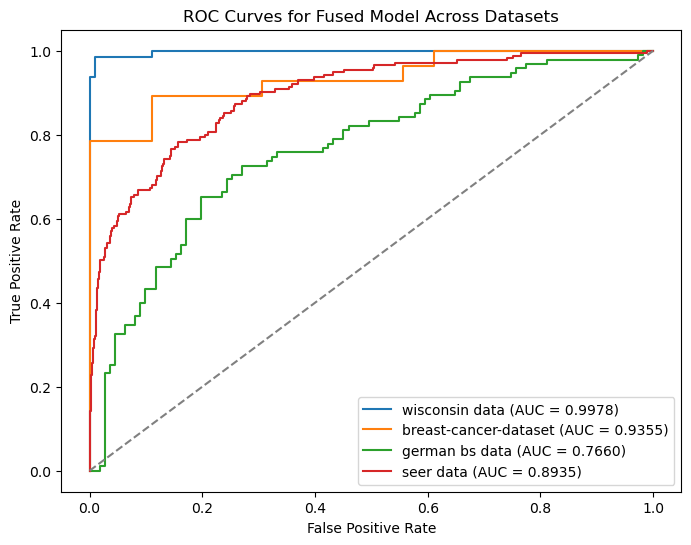

In [7]:

# 🌟 ROC Curves for All Datasets
plt.figure(figsize=(8, 6))
for dataset, fpr in all_fpr.items():
    plt.plot(fpr, all_tpr[dataset], label=f"{dataset} (AUC = {all_roc_auc[dataset]:.4f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Fused Model Across Datasets")
plt.legend()
plt.show()

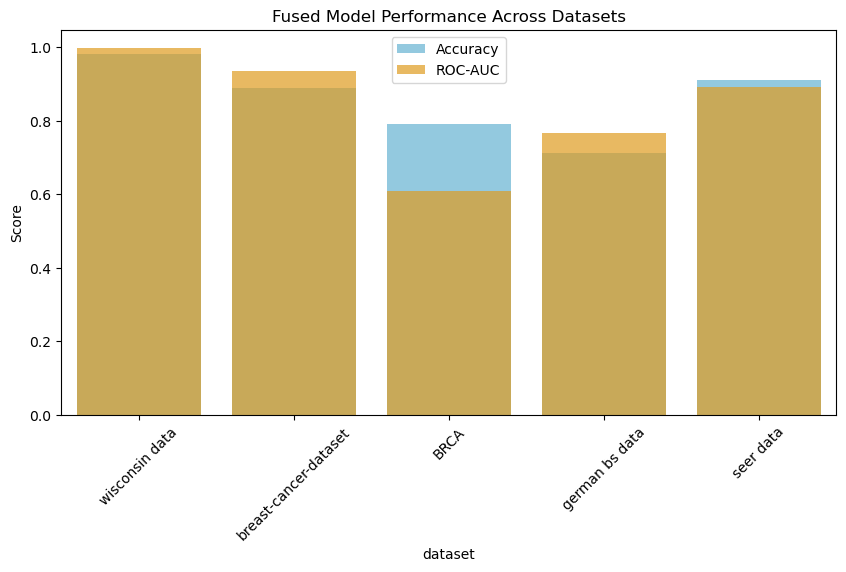

In [9]:
# 🌟 Accuracy & AUC Bar Plot
df_results = pd.DataFrame(evaluation_results)
plt.figure(figsize=(10, 5))
sns.barplot(x="dataset", y="fused_accuracy", data=df_results, color="skyblue", label="Accuracy")
sns.barplot(x="dataset", y="fused_roc_auc", data=df_results, color="orange", label="ROC-AUC", alpha=0.7)
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.title("Fused Model Performance Across Datasets")
plt.legend()
plt.show()

